In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from torch.nn.parameter import Parameter
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:1


In [2]:
#New Version After Learning to simulate burger's equation in matlab!!
data = scipy.io.loadmat('burgers_shock_10sin.mat')  	# Load data from file

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

label = "QCRE_2D_5_atanh_NW"
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']   

#usol = usol/1000# solution of 256x100 grid points


X, T = np.meshgrid(x,t)   

In [3]:
def trainingdata(N_u,N_f,seed):

    '''Boundary Conditions'''
    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    np.random.seed(seed)
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train

In [4]:
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_true = usol.flatten('F')[:,None]

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        self.alpha_val = []
        
        self.n = torch.tensor(1.0)
        
    'foward pass'
    def forward(self,x):
         if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
         u_b = torch.from_numpy(ub).float().to(device)
         l_b = torch.from_numpy(lb).float().to(device)
                      
         #preprocessing input 
         x = (x - l_b)/(u_b - l_b) #feature scaling
        
         #convert to float
         a = x.float()
                        
         '''     
         Alternatively:
        
         a = self.activation(self.fc1(a))
         a = self.activation(self.fc2(a))
         a = self.activation(self.fc3(a))
         a = self.fc4(a)
         
         '''
        
         for i in range(len(layers)-2):
                z = self.linears[i](a)
                a = self.activation(self.n*self.alpha[:,i]*z)  
         
         a = self.linears[-1](a)
        
         return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f,f_hat):
        
        nu = 0.01/pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f,f_hat):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f,f_hat)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(X_u_train, u_train, X_f_train,f_hat)
        
        self.train_loss.append(loss.cpu().detach().numpy())
        
        
        u_pred = self.test(X_u_test_tensor)
        self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1))))
        self.alpha_val.append(self.alpha.cpu().detach().numpy())
        
        print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        
        loss.backward()
        self.iter += 1
     
        return loss        
    'test neural network'
    
    def test(self,xt_test_tensor):
        u_pred = self.forward(X_u_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []
alpha_full = []
elapsed_time= np.zeros((max_reps,1))


for reps in range(max_reps):
    print(reps)
    N_u = 200 #Total number of data points for 'u'
    N_f = 10000 #Total number of collocation points 
    
    X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,reps*43)
        
    X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
    X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
        
    u = torch.from_numpy(u_true).float().to(device)
    f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
        

    X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
    'Convert to tensor and send to GPU'


    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
       
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                                  max_iter = 3000, 
                                  max_eval = None, 
                                  tolerance_grad = -1, 
                                  tolerance_change = -1, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')

    start_time = time.time()

    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    alpha_full.append(PINN.alpha_val)
    

mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "alpha": alpha_full, "label": label}
savemat(label+'.mat', mdic) 

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 28.172722 Test Loss 24.561405385541537
1 Train Loss 27.637928 Test Loss 24.566129636045247
2 Train Loss 26.337048 Test Loss 24.538868100196723
3 Train Loss 26.251556 Test Loss 24.46691011442614
4 Train Loss 25.634264 Test Loss 23.915923507175076
5 Train Loss 25.68262 Test Loss 22.532408

145 Train Loss 15.862681 Test Loss 12.533355146557833
146 Train Loss 15.858807 Test Loss 12.576877100071144
147 Train Loss 15.8306675 Test Loss 12.556253548857399
148 Train Loss 15.810736 Test Loss 12.550648902581521
149 Train Loss 15.799094 Test Loss 12.564573281325163
150 Train Loss 15.791297 Test Loss 12.533560786782408
151 Train Loss 15.786315 Test Loss 12.521424008013357
152 Train Loss 15.780549 Test Loss 12.507473709159486
153 Train Loss 15.77597 Test Loss 12.50203127123385
154 Train Loss 15.756676 Test Loss 12.484472758766781
155 Train Loss 15.718729 Test Loss 12.420773527191802
156 Train Loss 15.650168 Test Loss 12.401562155813409
157 Train Loss 15.574538 Test Loss 12.342591126339952
158 Train Loss 15.621277 Test Loss 12.278578500828312
159 Train Loss 15.531352 Test Loss 12.31335931072952
160 Train Loss 15.546268 Test Loss 12.38697040294484
161 Train Loss 15.507341 Test Loss 12.340981404704443
162 Train Loss 15.497004 Test Loss 12.322135638345102
163 Train Loss 15.491437 Test L

302 Train Loss 13.940241 Test Loss 11.634412755304124
303 Train Loss 13.926496 Test Loss 11.627980472726925
304 Train Loss 13.911219 Test Loss 11.621920083925229
305 Train Loss 14.19832 Test Loss 11.571944515165926
306 Train Loss 13.898674 Test Loss 11.604467523695874
307 Train Loss 13.878965 Test Loss 11.587317482960136
308 Train Loss 13.856839 Test Loss 11.549664286401741
309 Train Loss 13.844 Test Loss 11.509976418585127
310 Train Loss 13.854429 Test Loss 11.46953805333873
311 Train Loss 13.837226 Test Loss 11.490383188475926
312 Train Loss 13.834319 Test Loss 11.49553978471435
313 Train Loss 13.832727 Test Loss 11.496154061433934
314 Train Loss 13.83228 Test Loss 11.494781150485966
315 Train Loss 13.831679 Test Loss 11.495381251695408
316 Train Loss 13.834574 Test Loss 11.514344391988656
317 Train Loss 13.830741 Test Loss 11.501672312904246
318 Train Loss 13.828876 Test Loss 11.51305638194379
319 Train Loss 13.825689 Test Loss 11.521320686848389
320 Train Loss 13.819266 Test Loss 1

458 Train Loss 13.347872 Test Loss 11.221190033539886
459 Train Loss 13.340271 Test Loss 11.229222054843978
460 Train Loss 13.345674 Test Loss 11.217077347386637
461 Train Loss 13.33522 Test Loss 11.222302139767724
462 Train Loss 13.330443 Test Loss 11.220683306420371
463 Train Loss 13.326412 Test Loss 11.228630955120682
464 Train Loss 13.324511 Test Loss 11.225897985627672
465 Train Loss 13.32255 Test Loss 11.218222510432348
466 Train Loss 13.329966 Test Loss 11.224654127644353
467 Train Loss 13.322059 Test Loss 11.219541838603238
468 Train Loss 13.319679 Test Loss 11.225694101379371
469 Train Loss 13.339137 Test Loss 11.23044482222033
470 Train Loss 13.318916 Test Loss 11.22635851359767
471 Train Loss 13.316067 Test Loss 11.231485937183384
472 Train Loss 13.312746 Test Loss 11.231327546135722
473 Train Loss 13.350355 Test Loss 11.23954019240586
474 Train Loss 13.3114 Test Loss 11.232689138231484
475 Train Loss 13.308337 Test Loss 11.22561569530487
476 Train Loss 13.307377 Test Loss 1

614 Train Loss 12.970451 Test Loss 11.097164670596351
615 Train Loss 12.968628 Test Loss 11.096113722154467
616 Train Loss 12.966459 Test Loss 11.095667052648226
617 Train Loss 12.964581 Test Loss 11.095055627502052
618 Train Loss 12.963276 Test Loss 11.097552320376005
619 Train Loss 12.961599 Test Loss 11.102069198250618
620 Train Loss 12.96048 Test Loss 11.10591820721844
621 Train Loss 12.959057 Test Loss 11.107042180797732
622 Train Loss 12.957352 Test Loss 11.105383109279021
623 Train Loss 12.955657 Test Loss 11.09868448225353
624 Train Loss 12.9541 Test Loss 11.094238811727555
625 Train Loss 12.952121 Test Loss 11.091891906325264
626 Train Loss 12.950192 Test Loss 11.09415790296825
627 Train Loss 12.948469 Test Loss 11.098373554310081
628 Train Loss 12.946464 Test Loss 11.105293977830568
629 Train Loss 12.945152 Test Loss 11.104460331075048
630 Train Loss 12.942523 Test Loss 11.09921647447181
631 Train Loss 12.940949 Test Loss 11.094121812707995
632 Train Loss 12.93868 Test Loss 1

772 Train Loss 12.73551 Test Loss 11.009160254611663
773 Train Loss 20.330435 Test Loss 10.960141611199335
774 Train Loss 12.7352705 Test Loss 11.008911118743228
775 Train Loss 12.743056 Test Loss 11.015576583935596
776 Train Loss 12.734882 Test Loss 11.010049477092753
777 Train Loss 35.471947 Test Loss 11.040512272632926
778 Train Loss 12.73488 Test Loss 11.010072249429335
779 Train Loss 12.754604 Test Loss 11.016381482543915
780 Train Loss 12.73457 Test Loss 11.011047852044102
781 Train Loss 12.732687 Test Loss 11.009669024229995
782 Train Loss 12.726744 Test Loss 10.999162680228123
783 Train Loss 12.742302 Test Loss 10.996054488664232
784 Train Loss 12.723379 Test Loss 10.997189187702508
785 Train Loss 12.708145 Test Loss 10.980358527090335
786 Train Loss 12.700606 Test Loss 10.962489742981987
787 Train Loss 12.693534 Test Loss 10.967503863746678
788 Train Loss 12.734344 Test Loss 10.947281736328865
789 Train Loss 12.676855 Test Loss 10.956952208155045
790 Train Loss 13.0565 Test Lo

928 Train Loss 12.432405 Test Loss 10.768545451403831
929 Train Loss 12.433554 Test Loss 10.770543879178163
930 Train Loss 12.4314785 Test Loss 10.769258827562833
931 Train Loss 12.428583 Test Loss 10.770204107362018
932 Train Loss 12.42059 Test Loss 10.767893735972073
933 Train Loss 12.41684 Test Loss 10.764883862448317
934 Train Loss 12.41851 Test Loss 10.765247718867816
935 Train Loss 12.409071 Test Loss 10.765124762135434
936 Train Loss 12.402521 Test Loss 10.765874381297301
937 Train Loss 12.390601 Test Loss 10.77047144206687
938 Train Loss 12.418516 Test Loss 10.766632184258029
939 Train Loss 12.387696 Test Loss 10.76955505406169
940 Train Loss 12.390854 Test Loss 10.746068662991252
941 Train Loss 12.383751 Test Loss 10.758961054273145
942 Train Loss 12.39465 Test Loss 10.76226507869268
943 Train Loss 12.379078 Test Loss 10.75936541481917
944 Train Loss 12.39868 Test Loss 10.765815248114084
945 Train Loss 12.377051 Test Loss 10.761002370572111
946 Train Loss 12.373765 Test Loss 1

1084 Train Loss 12.174878 Test Loss 10.672717290953335
1085 Train Loss 12.177658 Test Loss 10.667050353225216
1086 Train Loss 12.174553 Test Loss 10.671274632816182
1087 Train Loss 12.173673 Test Loss 10.670050863283139
1088 Train Loss 12.17308 Test Loss 10.670436554764533
1089 Train Loss 12.1726885 Test Loss 10.670817812237754
1090 Train Loss 12.172265 Test Loss 10.670625381917418
1091 Train Loss 12.171223 Test Loss 10.67124743692829
1092 Train Loss 12.170449 Test Loss 10.670124119159809
1093 Train Loss 12.168947 Test Loss 10.667115974183737
1094 Train Loss 12.167556 Test Loss 10.662890959990785
1095 Train Loss 12.165513 Test Loss 10.658550129682773
1096 Train Loss 12.179288 Test Loss 10.648134530054755
1097 Train Loss 12.164396 Test Loss 10.655459039457751
1098 Train Loss 12.163103 Test Loss 10.645877118599401
1099 Train Loss 12.161749 Test Loss 10.64928475651713
1100 Train Loss 12.160177 Test Loss 10.65068450646136
1101 Train Loss 12.158449 Test Loss 10.654892658788185
1102 Train Lo

1234 Train Loss 12.058505 Test Loss 10.603841379971248
1235 Train Loss 12.057938 Test Loss 10.60407472463802
1236 Train Loss 12.056131 Test Loss 10.601869884140163
1237 Train Loss 12.055806 Test Loss 10.599919398622113
1238 Train Loss 12.055428 Test Loss 10.600665982790497
1239 Train Loss 12.052901 Test Loss 10.598299794480619
1240 Train Loss 12.049677 Test Loss 10.596098483237824
1241 Train Loss 12.044506 Test Loss 10.586200182628803
1242 Train Loss 12.071715 Test Loss 10.576390279644768
1243 Train Loss 12.043818 Test Loss 10.584286067455754
1244 Train Loss 12.043582 Test Loss 10.581082078361758
1245 Train Loss 12.042741 Test Loss 10.582537422884464
1246 Train Loss 12.041905 Test Loss 10.58206182324086
1247 Train Loss 12.040844 Test Loss 10.58182152400685
1248 Train Loss 12.04007 Test Loss 10.5828152278448
1249 Train Loss 12.039091 Test Loss 10.583686312198354
1250 Train Loss 12.038059 Test Loss 10.581892739428536
1251 Train Loss 12.039555 Test Loss 10.577616821646531
1252 Train Loss 

1386 Train Loss 11.954493 Test Loss 10.5446393107194
1387 Train Loss 11.953228 Test Loss 10.548088301791934
1388 Train Loss 11.951662 Test Loss 10.545076631576421
1389 Train Loss 11.949321 Test Loss 10.543399896127177
1390 Train Loss 11.9470215 Test Loss 10.541536647982994
1391 Train Loss 11.945757 Test Loss 10.54272820881497
1392 Train Loss 11.945002 Test Loss 10.544733330560545
1393 Train Loss 11.946469 Test Loss 10.547716815015404
1394 Train Loss 11.944746 Test Loss 10.545581464466
1395 Train Loss 11.944421 Test Loss 10.545527474064802
1396 Train Loss 11.943864 Test Loss 10.545538286522142
1397 Train Loss 11.943091 Test Loss 10.545354459722045
1398 Train Loss 11.941685 Test Loss 10.545655065487432
1399 Train Loss 12.398882 Test Loss 10.567582161437095
1400 Train Loss 11.942275 Test Loss 10.547268251473135
1401 Train Loss 11.941625 Test Loss 10.54601620603543
1402 Train Loss 11.939511 Test Loss 10.547154920133607
1403 Train Loss 11.942843 Test Loss 10.55274874294783
1404 Train Loss 1

1540 Train Loss 11.79987 Test Loss 10.41260879187422
1541 Train Loss 11.797171 Test Loss 10.403858375871346
1542 Train Loss 11.796777 Test Loss 10.399758220424985
1543 Train Loss 11.795784 Test Loss 10.401570452500813
1544 Train Loss 11.797875 Test Loss 10.400714686076821
1545 Train Loss 11.795092 Test Loss 10.401251826246769
1546 Train Loss 11.793146 Test Loss 10.401914500572536
1547 Train Loss 11.791021 Test Loss 10.403753859583835
1548 Train Loss 11.789238 Test Loss 10.397874176854955
1549 Train Loss 11.78784 Test Loss 10.393751950569524
1550 Train Loss 11.786627 Test Loss 10.38975377641829
1551 Train Loss 11.785583 Test Loss 10.390285582469746
1552 Train Loss 11.784554 Test Loss 10.3906939535322
1553 Train Loss 11.783428 Test Loss 10.3912199210674
1554 Train Loss 11.782871 Test Loss 10.388624925031632
1555 Train Loss 11.781919 Test Loss 10.386131190324356
1556 Train Loss 11.781004 Test Loss 10.382930772099236
1557 Train Loss 11.78137 Test Loss 10.37596850364427
1558 Train Loss 11.7

1694 Train Loss 11.586387 Test Loss 10.233171102993026
1695 Train Loss 11.588239 Test Loss 10.23377740045229
1696 Train Loss 11.584234 Test Loss 10.233400791836303
1697 Train Loss 11.584797 Test Loss 10.233339159095785
1698 Train Loss 11.582956 Test Loss 10.23332579527435
1699 Train Loss 11.57933 Test Loss 10.239221103731925
1700 Train Loss 11.575133 Test Loss 10.251863493174659
1701 Train Loss 11.579335 Test Loss 10.255952406234739
1702 Train Loss 11.573745 Test Loss 10.253315974276024
1703 Train Loss 11.571899 Test Loss 10.251643696480373
1704 Train Loss 11.570317 Test Loss 10.25301462520491
1705 Train Loss 11.568634 Test Loss 10.253047601348426
1706 Train Loss 11.566614 Test Loss 10.256187151839175
1707 Train Loss 11.565984 Test Loss 10.258702300121877
1708 Train Loss 11.565054 Test Loss 10.257643192141325
1709 Train Loss 11.563465 Test Loss 10.254711107635714
1710 Train Loss 11.562295 Test Loss 10.251418448506689
1711 Train Loss 11.561716 Test Loss 10.251028527807723
1712 Train Los

1844 Train Loss 11.315657 Test Loss 10.148517424381726
1845 Train Loss 11.31342 Test Loss 10.148298406908365
1846 Train Loss 11.326327 Test Loss 10.140359537719608
1847 Train Loss 11.30985 Test Loss 10.1450889765136
1848 Train Loss 11.306152 Test Loss 10.145994874530679
1849 Train Loss 11.303741 Test Loss 10.147481422599393
1850 Train Loss 11.300979 Test Loss 10.147575829000838
1851 Train Loss 11.298895 Test Loss 10.146964229208276
1852 Train Loss 11.297285 Test Loss 10.150095646405925
1853 Train Loss 11.294608 Test Loss 10.149734215450044
1854 Train Loss 11.291393 Test Loss 10.147149310498222
1855 Train Loss 11.2850065 Test Loss 10.142753987591759
1856 Train Loss 11.284112 Test Loss 10.140955050561471
1857 Train Loss 11.281941 Test Loss 10.135701650527565
1858 Train Loss 11.279634 Test Loss 10.139242601139259
1859 Train Loss 11.277335 Test Loss 10.142381649137732
1860 Train Loss 11.276108 Test Loss 10.139911172802513
1861 Train Loss 11.275144 Test Loss 10.140150825496386
1862 Train Lo

1997 Train Loss 11.17234 Test Loss 10.132692638188724
1998 Train Loss 11.172174 Test Loss 10.132679785017949
1999 Train Loss 11.172044 Test Loss 10.132893758976774
2000 Train Loss 11.171821 Test Loss 10.133214491174094
2001 Train Loss 11.171614 Test Loss 10.133618797793885
2002 Train Loss 11.1714 Test Loss 10.134107936576607
2003 Train Loss 11.1712675 Test Loss 10.134043001925425
2004 Train Loss 11.171185 Test Loss 10.133870355972759
2005 Train Loss 11.171131 Test Loss 10.133975223277849
2006 Train Loss 11.171053 Test Loss 10.134214395639075
2007 Train Loss 11.170953 Test Loss 10.134808026385622
2008 Train Loss 11.170841 Test Loss 10.135475341031498
2009 Train Loss 11.170726 Test Loss 10.136012153788934
2010 Train Loss 11.170603 Test Loss 10.136326457806737
2011 Train Loss 11.170469 Test Loss 10.136710851247088
2012 Train Loss 11.170303 Test Loss 10.137123693703552
2013 Train Loss 11.170135 Test Loss 10.137788617822888
2014 Train Loss 11.170018 Test Loss 10.137930368251721
2015 Train L

2150 Train Loss 11.082374 Test Loss 10.128691097717812
2151 Train Loss 11.081856 Test Loss 10.129310369259763
2152 Train Loss 11.086099 Test Loss 10.131181707504606
2153 Train Loss 11.081472 Test Loss 10.12969634391172
2154 Train Loss 11.081077 Test Loss 10.130649540922748
2155 Train Loss 11.081327 Test Loss 10.13519625882837
2156 Train Loss 11.080378 Test Loss 10.13270941556557
2157 Train Loss 11.079834 Test Loss 10.132069302454335
2158 Train Loss 11.079317 Test Loss 10.132764406657419
2159 Train Loss 11.078856 Test Loss 10.134498455020749
2160 Train Loss 11.0789995 Test Loss 10.13219595707444
2161 Train Loss 11.078636 Test Loss 10.133450753048724
2162 Train Loss 11.078263 Test Loss 10.13279446924747
2163 Train Loss 11.0778265 Test Loss 10.133055379963153
2164 Train Loss 11.0802145 Test Loss 10.136935527833526
2165 Train Loss 11.077729 Test Loss 10.13366815609461
2166 Train Loss 11.077212 Test Loss 10.132793236382604
2167 Train Loss 11.076851 Test Loss 10.132176584214335
2168 Train Lo

2303 Train Loss 10.972931 Test Loss 10.103336586756264
2304 Train Loss 10.964783 Test Loss 10.106522618466391
2305 Train Loss 10.975518 Test Loss 10.08737046392061
2306 Train Loss 10.963732 Test Loss 10.10185676250094
2307 Train Loss 10.96207 Test Loss 10.101143944505942
2308 Train Loss 10.96084 Test Loss 10.10051962005082
2309 Train Loss 10.973286 Test Loss 10.097339230787032
2310 Train Loss 10.960335 Test Loss 10.099654373563538
2311 Train Loss 10.95902 Test Loss 10.098917474309266
2312 Train Loss 10.961991 Test Loss 10.10239866917292
2313 Train Loss 10.958539 Test Loss 10.099814467026647
2314 Train Loss 10.95747 Test Loss 10.09943627451437
2315 Train Loss 10.959902 Test Loss 10.099317538744273
2316 Train Loss 10.9572315 Test Loss 10.099385831077868
2317 Train Loss 10.956712 Test Loss 10.09935588452282
2318 Train Loss 10.955989 Test Loss 10.098846566461924
2319 Train Loss 10.955727 Test Loss 10.097978092789912
2320 Train Loss 10.954868 Test Loss 10.096139484876097
2321 Train Loss 10.

2457 Train Loss 10.838395 Test Loss 10.057929536909006
2458 Train Loss 10.838254 Test Loss 10.057277011270106
2459 Train Loss 10.838143 Test Loss 10.056574268260917
2460 Train Loss 10.837962 Test Loss 10.055480313338984
2461 Train Loss 10.837698 Test Loss 10.054064536749289
2462 Train Loss 10.8376255 Test Loss 10.052876521346093
2463 Train Loss 10.837343 Test Loss 10.05296319616999
2464 Train Loss 10.837177 Test Loss 10.053513292124544
2465 Train Loss 10.836871 Test Loss 10.053358818437227
2466 Train Loss 10.835972 Test Loss 10.051538717098719
2467 Train Loss 10.838047 Test Loss 10.053246875752818
2468 Train Loss 10.835758 Test Loss 10.051852295555738
2469 Train Loss 10.8355255 Test Loss 10.052247637598407
2470 Train Loss 10.834875 Test Loss 10.051276820176199
2471 Train Loss 10.834603 Test Loss 10.0502705056116
2472 Train Loss 10.834174 Test Loss 10.049032122471084
2473 Train Loss 10.833502 Test Loss 10.048216044681983
2474 Train Loss 10.83261 Test Loss 10.046664807614683
2475 Train L

2610 Train Loss 10.616152 Test Loss 9.942967234797193
2611 Train Loss 10.612038 Test Loss 9.943480739595662
2612 Train Loss 10.610054 Test Loss 9.941788654287523
2613 Train Loss 10.607067 Test Loss 9.936991725437974
2614 Train Loss 10.605807 Test Loss 9.934794815824889
2615 Train Loss 10.604382 Test Loss 9.934298726360824
2616 Train Loss 10.603406 Test Loss 9.935501736105603
2617 Train Loss 10.603032 Test Loss 9.936434024294437
2618 Train Loss 10.601417 Test Loss 9.936169424713993
2619 Train Loss 10.600552 Test Loss 9.934912479115056
2620 Train Loss 10.599016 Test Loss 9.936044375746242
2621 Train Loss 10.597438 Test Loss 9.936339490585803
2622 Train Loss 10.595634 Test Loss 9.936356134204503
2623 Train Loss 10.594158 Test Loss 9.936379017393524
2624 Train Loss 10.5960455 Test Loss 9.931767731251881
2625 Train Loss 10.593057 Test Loss 9.93456941160646
2626 Train Loss 10.591182 Test Loss 9.934862096155355
2627 Train Loss 10.588645 Test Loss 9.933588280950465
2628 Train Loss 10.588934 Te

2766 Train Loss 10.390019 Test Loss 9.912766028230203
2767 Train Loss 10.389102 Test Loss 9.914995645519298
2768 Train Loss 10.387302 Test Loss 9.915479706645648
2769 Train Loss 10.385447 Test Loss 9.916101183470815
2770 Train Loss 10.382889 Test Loss 9.911704388835881
2771 Train Loss 10.380968 Test Loss 9.91173132521315
2772 Train Loss 10.378812 Test Loss 9.909885088724936
2773 Train Loss 10.375817 Test Loss 9.906125153170318
2774 Train Loss 10.373187 Test Loss 9.903499762718194
2775 Train Loss 10.369217 Test Loss 9.900415048891885
2776 Train Loss 10.425726 Test Loss 9.918228634971472
2777 Train Loss 10.368184 Test Loss 9.902358415403388
2778 Train Loss 10.366017 Test Loss 9.903126569380246
2779 Train Loss 10.38146 Test Loss 9.902050399158865
2780 Train Loss 10.363659 Test Loss 9.902548696021267
2781 Train Loss 10.362259 Test Loss 9.902574746119932
2782 Train Loss 10.357897 Test Loss 9.89906568076447
2783 Train Loss 10.353907 Test Loss 9.893954046933631
2784 Train Loss 10.349849 Test 

2921 Train Loss 10.093954 Test Loss 9.83644880475452
2922 Train Loss 10.070271 Test Loss 9.838478159475217
2923 Train Loss 10.068372 Test Loss 9.837399163219091
2924 Train Loss 10.066599 Test Loss 9.83523867673501
2925 Train Loss 10.06502 Test Loss 9.833702295099025
2926 Train Loss 10.063621 Test Loss 9.832339685469949
2927 Train Loss 10.062285 Test Loss 9.83071957638685
2928 Train Loss 10.060656 Test Loss 9.830547679921676
2929 Train Loss 10.061538 Test Loss 9.822270065923602
2930 Train Loss 10.059538 Test Loss 9.826909658374793
2931 Train Loss 10.056929 Test Loss 9.827446583684859
2932 Train Loss 10.051942 Test Loss 9.828421887858681
2933 Train Loss 10.055206 Test Loss 9.830047375465005
2934 Train Loss 10.051027 Test Loss 9.828913917107288
2935 Train Loss 10.048904 Test Loss 9.827483821889395
2936 Train Loss 10.04668 Test Loss 9.82669135685009
2937 Train Loss 10.044716 Test Loss 9.826330956453699
2938 Train Loss 10.043255 Test Loss 9.825220609531932
2939 Train Loss 10.042058 Test Los

3077 Train Loss 9.842361 Test Loss 9.786779121815076
3078 Train Loss 9.839172 Test Loss 9.787648946800742
3079 Train Loss 9.840214 Test Loss 9.78737487333181
3080 Train Loss 9.838104 Test Loss 9.787479009817558
3081 Train Loss 9.836511 Test Loss 9.786490758524439
3082 Train Loss 9.834702 Test Loss 9.786071507722218
3083 Train Loss 9.832387 Test Loss 9.785773902475476
3084 Train Loss 9.829633 Test Loss 9.785555821119157
3085 Train Loss 9.82677 Test Loss 9.785484374325671
3086 Train Loss 9.8411255 Test Loss 9.780240075859483
3087 Train Loss 9.82444 Test Loss 9.783875275222602
3088 Train Loss 9.825807 Test Loss 9.786783830571478
3089 Train Loss 9.822942 Test Loss 9.784989193931823
3090 Train Loss 9.833278 Test Loss 9.797671913089783
3091 Train Loss 9.82172 Test Loss 9.788008160147148
3092 Train Loss 9.844922 Test Loss 9.765929343282366
3093 Train Loss 9.820702 Test Loss 9.784182621284891
3094 Train Loss 9.816057 Test Loss 9.78304679728154
3095 Train Loss 9.813107 Test Loss 9.7775582096447

3236 Train Loss 9.535823 Test Loss 9.667350362077592
3237 Train Loss 9.530556 Test Loss 9.662977228016478
3238 Train Loss 9.530146 Test Loss 9.664492886082908
3239 Train Loss 9.528988 Test Loss 9.66294749848083
3240 Train Loss 9.528426 Test Loss 9.662627569501149
3241 Train Loss 9.527905 Test Loss 9.662297184217474
3242 Train Loss 9.527218 Test Loss 9.662367640438804
3243 Train Loss 9.52666 Test Loss 9.662507006430044
3244 Train Loss 9.526094 Test Loss 9.662116379662974
3245 Train Loss 9.5254545 Test Loss 9.662416666761226
3246 Train Loss 9.524866 Test Loss 9.662041858710623
3247 Train Loss 9.524025 Test Loss 9.662190952379934
3248 Train Loss 9.523637 Test Loss 9.658910079586095
3249 Train Loss 9.522621 Test Loss 9.660959254105352
3250 Train Loss 9.526571 Test Loss 9.662889632373911
3251 Train Loss 9.521877 Test Loss 9.661462508011583
3252 Train Loss 9.520467 Test Loss 9.660957734288532
3253 Train Loss 9.518435 Test Loss 9.659977780438725
3254 Train Loss 9.517111 Test Loss 9.6585061551

3393 Train Loss 9.271999 Test Loss 9.515122423936774
3394 Train Loss 9.269895 Test Loss 9.515925348785002
3395 Train Loss 9.268045 Test Loss 9.516713097418801
3396 Train Loss 9.269502 Test Loss 9.52275311448255
3397 Train Loss 9.266966 Test Loss 9.519123656917055
3398 Train Loss 9.265806 Test Loss 9.519663680851435
3399 Train Loss 9.264873 Test Loss 9.520993733772924
3400 Train Loss 9.263683 Test Loss 9.520216053802557
3401 Train Loss 9.262518 Test Loss 9.518805928524612
3402 Train Loss 9.261359 Test Loss 9.515501637320696
3403 Train Loss 9.259968 Test Loss 9.516780204989397
3404 Train Loss 9.258204 Test Loss 9.5153822214805
3405 Train Loss 9.256611 Test Loss 9.51210943967566
3406 Train Loss 9.255125 Test Loss 9.510490496500717
3407 Train Loss 9.253349 Test Loss 9.508054879158664
3408 Train Loss 9.250501 Test Loss 9.504974124388982
3409 Train Loss 9.24673 Test Loss 9.502841260120377
3410 Train Loss 9.245102 Test Loss 9.5036094266783
3411 Train Loss 9.24086 Test Loss 9.499304697967117
3

3552 Train Loss 9.005759 Test Loss 9.403824673995961
3553 Train Loss 9.004694 Test Loss 9.402623556578591
3554 Train Loss 9.003626 Test Loss 9.401752055044145


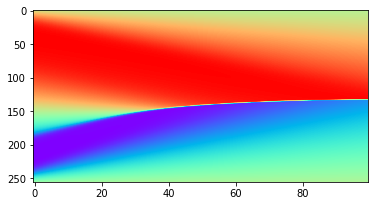

In [7]:
u_pred = PINN.test(X_u_test_tensor)

cmap = plt.cm.rainbow
plt.imshow(np.transpose(u_pred.reshape(100,256)),cmap = cmap,aspect = 0.2)

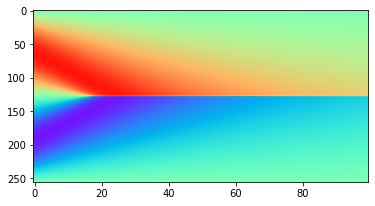

In [8]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(u_true.reshape(100,256)),cmap = cmap,aspect = 0.2)

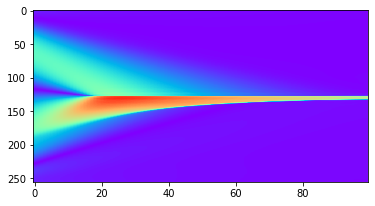

In [9]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(np.abs(u_pred - u_true).reshape(100,256)),cmap = cmap,aspect = 0.2)

In [10]:
a = 0 
for i in range(10):
    print(test_loss_full[i][-1])
    a = a + test_loss_full[i][-1]
print(a/10)

9.401752055044145


IndexError: list index out of range